In [24]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [25]:
print(torch.cuda.is_available())
print(torch.__version__)

True
1.10.0+cu113


In [26]:
train_set = torchvision.datasets.FashionMNIST(root = ".", train = True,
download = True, transform = transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".", train = False,
download = True, transform = transforms.ToTensor())
training_loader = torch.utils.data.DataLoader(train_set , batch_size = 32,
shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set , batch_size = 32,
shuffle = False)
torch.manual_seed(0)
# If you are using CuDNN, otherwise you can just ignore
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [27]:

print('The dimension of the train data:')
print(train_set.data.size())
print('\nThe dimension of the train labels:')
print(train_set.targets.size())

print('\n\nThe dimenstion of the validation data:')
print(test_set.data.size())
print('\nThe dimenstion of the validation labels:')
print(test_set.targets.size())

The dimension of the train data:
torch.Size([60000, 28, 28])

The dimension of the train labels:
torch.Size([60000])


The dimenstion of the validation data:
torch.Size([10000, 28, 28])

The dimenstion of the validation labels:
torch.Size([10000])


Dimension of input data: torch.Size([32, 1, 28, 28])
Dimension of labels: torch.Size([32])


<ipython-input-28-1e0f807b2196>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title("Label is: {}".format(label[0]), FontSize=16)


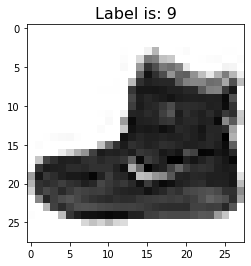

In [28]:
input_data, label = next(iter(training_loader))

print("Dimension of input data: {}".format(input_data.size()))
print("Dimension of labels: {}".format(label.size()))

plt.title("Label is: {}".format(label[0]), FontSize=16)
plt.imshow(input_data[0,:,:,:].numpy().reshape(28,28), cmap="gray_r");


In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [30]:
class FashionCNN(nn.Module):
    def __init__(self, activation_func):
        super(FashionCNN, self).__init__()
        # Set the activation function dynamically
        self.activation_func = activation_func
        
            
        self.conv_activ_maxpool_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),self.activation_func, nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5), self.activation_func ,nn.MaxPool2d(kernel_size=2),
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(4 * 4 * 64, 1024),
            self.activation_func,
            nn.Linear(1024, 256),
            self.activation_func,
            nn.Linear(256, 10), 
        )

        

    def forward(self, x):
        x = self.conv_activ_maxpool_stack(x)
        x = x.reshape(x.size(0), -1)
        x = self.fully_connected(x)
        return x
    

In [31]:

def weights_init(layer):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(layer.weight.data)
#     elif isinstance(layer, nn.Linear):
#         nn.init.xavier_uniform_(layer.weight.data)
#         nn.init.uniform_(layer.bias.data)



In [32]:
def evaluation(net, dataloader):
    
    total, correct = 0,0
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    return 100 * correct / total

# Training phase

def train_loop(net, loss_fn, optimizer, nepochs):
    
    max_epochs = nepochs
    loss_epoch_array = []
    loss_epoch = 0
    train_accuracy = []
    test_accuracy = []
    for epoch in range(max_epochs):
        loss_epoch = 0
        for i, data in enumerate(training_loader, 0):
            net.train()

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
        loss_epoch_array.append(loss_epoch)
        train_accuracy.append(evaluation(net, training_loader))
        test_accuracy.append(evaluation(net, test_loader))
        print("Epoch {}: loss: {}, train accuracy: {}, test accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))
        
    return loss_epoch_array, train_accuracy, test_accuracy
        

In [33]:
def build_network(act_func):
    """a helper function to build the network with different
        activation functions"""
    
    if act_func == "relu":
        act_func = nn.ReLU()
    elif act_func == "tanh":
        act_func = nn.Tanh()
    elif act_func == "sigmoid":
        act_func = nn.Sigmoid()
    elif act_func == "elu":
        act_func = nn.ELU()
    else:
        raise ValueError("Invalid activation function")
        
    net = FashionCNN(act_func).to(device)
    net.apply(weights_init)
    return net

In [11]:
net = build_network("relu")
print(net)


learning_rate = 0.1
num_epochs = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)


loss, train_accuracy, test_accuracy = train_loop(net, loss_fn, optimizer, num_epochs)

FashionCNN(
  (activation_func): ReLU()
  (conv_activ_maxpool_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoch 1: loss: 988.281118735671, train accuracy: 87.41, test accuracy:86.16
Epoch 2: loss: 602.5087904669344, train accuracy: 89.94333333333333, test accuracy:88.51
Epoch 3: loss: 509.48974922671914, train accuracy: 91.07333333333334, test accuracy:88.96
Epoch 4: loss: 446.1480039730668, train accuracy: 91.70333333333333, test accuracy:

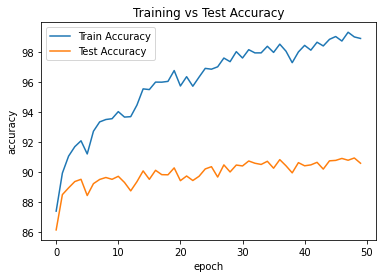

In [12]:
plt.plot(train_accuracy, '-')
plt.plot(test_accuracy, '-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.title('Training vs Test Accuracy')

plt.show()



# Different Activation Functions

In [13]:
net1 = build_network("tanh")
print(net1)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net1.parameters(), lr=learning_rate)
loss, train_accuracy, test_accuracy =train_loop(net1, loss_fn, optimizer, num_epochs)

FashionCNN(
  (activation_func): Tanh()
  (conv_activ_maxpool_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoch 1: loss: 858.0066684931517, train accuracy: 88.18666666666667, test accuracy:86.87
Epoch 2: loss: 591.1085127443075, train accuracy: 90.36166666666666, test accuracy:88.59
Epoch 3: loss: 496.3579468280077, train accuracy: 91.605, test accuracy:89.3
Epoch 4: loss: 424.7579086255282, train accuracy: 92.66, test accuracy:89.59
Epoch 

In [14]:
net2 = build_network("sigmoid")
print(net2)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=learning_rate)

loss, train_accuracy, test_accuracy = train_loop(net2, loss_fn, optimizer, num_epochs)

FashionCNN(
  (activation_func): Sigmoid()
  (conv_activ_maxpool_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoch 1: loss: 4338.827881097794, train accuracy: 10.0, test accuracy:10.0
Epoch 2: loss: 4319.959942102432, train accuracy: 10.0, test accuracy:10.0
Epoch 3: loss: 4319.074044704437, train accuracy: 10.0, test accuracy:10.0
Epoch 4: loss: 4317.879826545715, train accuracy: 10.0, test accuracy:10.0
Epoch 5: loss: 3221.807

In [15]:
net3 = build_network("elu")
print(net3)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net3.parameters(), lr=learning_rate)

loss, train_accuracy, test_accuracy = train_loop(net3, loss_fn, optimizer, num_epochs)

FashionCNN(
  (activation_func): ELU(alpha=1.0)
  (conv_activ_maxpool_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoch 1: loss: 855.819994956255, train accuracy: 88.08333333333333, test accuracy:86.85
Epoch 2: loss: 583.3678610697389, train accuracy: 90.12833333333333, test accuracy:88.61
Epoch 3: loss: 496.0812151376158, train accuracy: 91.21166666666667, test accuracy:89.27
Epoch 4: loss: 432.8424382172525

# Various learning rates with relu

In [16]:


learning_rates = [0.001, 0.1, 0.5, 1, 10]

for i in learning_rates:
    print("Learning rate value:", i, "\n")
    net = build_network("relu")
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=i)
    loss, train_accuracy, test_accuracy = train_loop(net, loss_fn, optimizer, num_epochs)
    
    print("\n\n\n\n\n")

Learning rate value: 0.001 

Epoch 1: loss: 3204.753550827503, train accuracy: 67.545, test accuracy:66.65
Epoch 2: loss: 1571.2325952649117, train accuracy: 72.63, test accuracy:71.93
Epoch 3: loss: 1367.6768291294575, train accuracy: 75.15666666666667, test accuracy:74.34
Epoch 4: loss: 1260.8536138236523, train accuracy: 76.94333333333333, test accuracy:76.0
Epoch 5: loss: 1185.9875341653824, train accuracy: 78.29666666666667, test accuracy:76.99
Epoch 6: loss: 1126.9965702146292, train accuracy: 79.325, test accuracy:78.17
Epoch 7: loss: 1077.7096402347088, train accuracy: 80.23, test accuracy:79.18
Epoch 8: loss: 1035.2026319354773, train accuracy: 80.94166666666666, test accuracy:79.92
Epoch 9: loss: 998.7867949008942, train accuracy: 81.605, test accuracy:80.66
Epoch 10: loss: 966.8140971362591, train accuracy: 82.225, test accuracy:81.41
Epoch 11: loss: 938.9353172630072, train accuracy: 82.74666666666667, test accuracy:81.84
Epoch 12: loss: 914.5808970034122, train accuracy: 8

Epoch 45: loss: 36.69275195169911, train accuracy: 98.56666666666666, test accuracy:90.54
Epoch 46: loss: 32.12833717940015, train accuracy: 98.95166666666667, test accuracy:90.48
Epoch 47: loss: 25.37751487146153, train accuracy: 98.45166666666667, test accuracy:89.97
Epoch 48: loss: 20.826310626179044, train accuracy: 98.29166666666667, test accuracy:90.13
Epoch 49: loss: 29.618664249233174, train accuracy: 98.65166666666667, test accuracy:90.57
Epoch 50: loss: 31.456982293923474, train accuracy: 98.24833333333333, test accuracy:90.36






Learning rate value: 0.5 

Epoch 1: loss: 1188.825760319829, train accuracy: 84.38333333333334, test accuracy:83.65
Epoch 2: loss: 729.5591546073556, train accuracy: 87.21333333333334, test accuracy:86.08
Epoch 3: loss: 630.3064063973725, train accuracy: 87.56833333333333, test accuracy:86.1
Epoch 4: loss: 572.8644783906639, train accuracy: 88.27333333333333, test accuracy:86.39
Epoch 5: loss: 544.488221751526, train accuracy: 89.76, test accuracy

Epoch 7: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 8: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 9: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 10: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 11: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 12: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 13: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 14: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 15: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 16: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 17: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 18: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 19: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 20: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 21: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 22: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 23: l

In [41]:


class FashionCNNDropout(nn.Module):
    def __init__(self):
        super(FashionCNNDropout, self).__init__()
            
        self.conv_relu_maxpool_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5), nn.ReLU() ,nn.MaxPool2d(kernel_size=2),
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(4 * 4 * 64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            # Adding dropout to the second layer
            nn.Dropout(p=0.3),
            nn.Linear(256, 10),            
        )
        

    def forward(self, x):
        x = self.conv_relu_maxpool_stack(x)
        x = x.reshape(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [42]:
model = FashionCNNDropout().to(device)
model.apply(weights_init)
print(model)


learning_rate = 0.1
num_epochs = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


loss, train_accuracy, test_accuracy = train_loop(model, loss_fn, optimizer, num_epochs)

FashionCNNDropout(
  (conv_relu_maxpool_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.9, inplace=False)
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoch 1: loss: 1581.8624825328588, train accuracy: 84.95166666666667, test accuracy:83.87
Epoch 2: loss: 971.803536914289, train accuracy: 87.58833333333334, test accuracy:86.84
Epoch 3: loss: 846.1222312822938, train accuracy: 88.795, test accuracy:87.51
Epoch 4: loss: 761.8741301521659, train accuracy: 89.553333333333

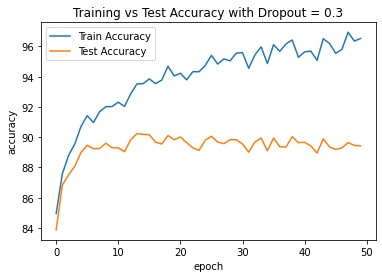

In [43]:
plt.plot(train_accuracy, '-')
plt.plot(test_accuracy, '-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.title('Training vs Test Accuracy with Dropout = 0.3')

plt.show()